In [1]:
import os
import warnings
warnings.filterwarnings(action='once')
from nilearn import datasets
from nilearn.input_data import NiftiMasker
import numpy as np
# cognitive annotations
import pandas as pd
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Sequence, Any
from deepmeg.preprocessing.transforms import one_hot_encoder, zscore
from deepmeg.data.datasets import EpochsDataset
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchmetrics
from deepmeg.training.callbacks import EarlyStopping, PrintingCallback, L2Reg
from deepmeg.utils.viz import plot_metrics
from functools import partial
from deepmeg.utils.convtools import compute_output_shape, conviter
import torch.nn.init as init
import math
from deepmeg.preprocessing.transforms import one_hot_encoder, one_hot_decoder
import nibabel as nb
import nilearn.plotting as nplt


def accuracy(predictions, targets):
    """
    Computes the accuracy metric for multiclass tasks with one-hot encoded labels.

    Args:
    - predictions: A PyTorch tensor of shape (batch_size, num_classes) representing the model's predictions.
    - targets: A PyTorch tensor of shape (batch_size, num_classes) representing the true labels in one-hot encoded format.

    Returns:
    - accuracy: A float value representing the accuracy metric.
    """

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy


def plot_2d_projections(matrix: np.ndarray, cmap=None) -> plt.Figure:
    """
    Plot the mean projections of a 3D matrix along the X, Y, and Z axes.

    Args:
        matrix (np.ndarray): A 3D matrix to plot.

    Returns:
        plt.Figure: A matplotlib Figure object containing the 2D projections along the X, Y, and Z axes.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(np.flip(matrix.mean(axis=0).T, 0), cmap=cmap)
    ax2.imshow(np.flip(matrix.mean(axis=1).T, 0), cmap=cmap)
    ax3.imshow(np.flip(matrix.mean(axis=2).T, 0), cmap=cmap)
    return fig

/home/user/Projects/deepmeg/venv/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [34]:
def mode_n_product(x, m, mode):
    x = np.asarray(x)
    m = np.asarray(m)
    if mode < 0:
        raise ValueError('`mode` must be a positive interger')
    if x.ndim < mode:
        raise ValueError('Invalid shape of X for mode = {}: {}'.format(mode, x.shape))
    if m.ndim != 2:
        raise ValueError('Invalid shape of M: {}'.format(m.shape))
    return np.swapaxes(np.swapaxes(x, mode, -1).dot(m.T), mode, -1)


A = np.reshape(np.arange(12) + 1, (2, 2, 3))
B = np.reshape(np.arange(6) + 1, (3, 2))

c = mode_n_product(A, B, 1)

In [35]:
c[0, :, :]

tensor([[ 9, 12, 15],
        [19, 26, 33],
        [29, 40, 51]])

In [36]:
B@A[0, :, :]

array([[ 9, 12, 15],
       [19, 26, 33],
       [29, 40, 51]])

In [37]:
A.shape, B.shape, c.shape

((2, 2, 3), (3, 2), torch.Size([2, 3, 3]))

In [38]:
d = np.tensordot(B, A, axes=([1],[1]))

In [39]:
c.shape

torch.Size([2, 3, 3])

In [40]:
c[0, :, :]

tensor([[ 9, 12, 15],
        [19, 26, 33],
        [29, 40, 51]])

In [41]:
x, y, z = 100, 100, 100
m, n, p = 10, 10, 10

print(
    x*n + y*m + z*p + m*n*p,
    x*m*p + n*y*p + n*m*z,
    (x*m*p + n*y*p + n*m*z) / (x*n + y*m + z*p + m*n*p)
)
B1, B2, B3 = np.random.random((x, m)) - .5, np.random.random((y, n)) - .5, np.random.random((z, p)) - .5
g = np.random.random((m, n, p)) - .5

4000 30000 7.5


In [42]:
B1.shape, B2.shape, B3.shape, g.shape

((100, 10), (100, 10), (100, 10), (10, 10, 10))

In [43]:
# Im1 = np.tensordot(B1, g, axes=([1],[1]))
Im1 = mode_n_product(g, B1, 0)
Im2 = mode_n_product(Im1, B2, 1)
Im3 = mode_n_product(Im2, B3, 2)
# Im2 = np.tensordot(B2, Im1, axes=([1],[1]))
Im3.shape

torch.Size([100, 100, 100])

In [54]:
np.expand_dims(B.copy().flatten(), 1).T @ np.expand_dims(B.copy().flatten(), 1)

array([[91]])

In [55]:
(B*B).sum()

91

In [2]:
def mode_n_product(x, m, axis):
    x = torch.as_tensor(x)
    m = torch.as_tensor(m)
    if axis < 0:
        raise ValueError('`mode` must be a positive integer')
    if x.ndim < axis:
        raise ValueError('Invalid shape of X for mode = {}: {}'.format(axis, x.shape))
    if m.ndim != 2:
        raise ValueError('Invalid shape of M: {}'.format(m.shape))

    # Move the mode axis to the last position
    x = x.permute(*list(range(axis)) + list(range(axis + 1, x.ndim)) + [axis])

    # Perform matrix multiplication
    result = torch.matmul(x, m.T)

    # Move the mode axis back to its original position
    result = result.permute(*list(range(axis)) + [result.ndim - 1] + list(range(axis, result.ndim - 1)))

    return result


class LinearTucker(nn.Module):
    def __init__(self, input_dim, kernel_size):

        super().__init__()
        self.input_dim = input_dim
        self.components = nn.ParameterList([
            nn.Parameter(
                torch.empty(m, h)
            )
            for m, h in zip(input_dim, kernel_size)
        ])
        self.kernel = nn.Parameter(torch.empty(*kernel_size))
        self.reset_parameters()

    def reset_parameters(self) -> None:

        for component in self.components:
            init.kaiming_uniform_(component, a=math.sqrt(5))

        init.kaiming_uniform_(self.kernel, a=math.sqrt(5))

    def forward(self, x):

        weights = self.get_weights()

        return x*weights

    def get_weights(self):

        out = self.kernel
        for i, component in enumerate(self.components):
            out = mode_n_product(out, component, i)

        return out

In [79]:
layer = LinearTucker((100, 100, 100), (10, 10, 10))

In [80]:
layer.components, layer.kernel.shape

(ParameterList(
     (0): Parameter containing: [torch.float32 of size 100x10]
     (1): Parameter containing: [torch.float32 of size 100x10]
     (2): Parameter containing: [torch.float32 of size 100x10]
 ),
 torch.Size([10, 10, 10]))

In [81]:
layer.get_weights().shape

torch.Size([100, 100, 100])

In [82]:
X = torch.randn(100, 100, 100)
layer(X).shape

torch.Size([100, 100, 100])

In [17]:
from deepmeg.models import BaseModel

class TcModel(BaseModel):
    def __init__(
        self,
        input_size,
        kernel_size,
        maxpool_size,
        n_classes: int,
        dropout=None
    ):
        super().__init__()
        self.n_classes = n_classes
        self.tc = LinearTucker(input_size, kernel_size)
        self.dp = None if dropout is None else nn.Dropout(dropout)
        self.maxpool = nn.MaxPool3d((maxpool_size, maxpool_size, maxpool_size), maxpool_size) if maxpool_size else False
        if not maxpool_size:
            convargs = (input_size, (1, 1, 1), 0, 1)
        else:
            convargs = (input_size, (maxpool_size, maxpool_size, maxpool_size), 0, maxpool_size)
        self.maxpool_shape = compute_output_shape(*convargs)
        self.num_features = np.prod(self.maxpool_shape)
        self.linear = nn.Linear(self.num_features, self.n_classes)


    def forward(self, x: torch.Tensor):
        x = torch.unsqueeze(x, 1)

        x = self.tc(x)
        if self.dp:
            x = self.dp(x)
        if self.maxpool:
            x = self.maxpool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)

        return x

In [4]:
X = torch.randn(1, 100, 100, 100)

model = TcModel((100, 100, 100), (10, 10, 10), 10, 5)
model(X)

tensor([[-2.7334, -0.0688,  0.6472,  0.0566,  0.1657]],
       grad_fn=<AddmmBackward0>)

In [160]:
model.maxpool_shape, model.num_features

((10, 10, 10), 1000)

## Huxby decoding

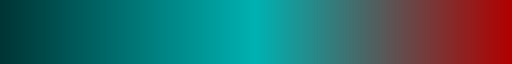

In [7]:
from deepmeg.utils.colors import generate_cmap

cmap = generate_cmap(*[
    '#003535',
    '#00b2b2',
    '#b20000'
])
cmap

In [174]:
dataset = EpochsDataset.load('../data/huxby_3d_not_cropped_preprocessed.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [5]:
dataset = EpochsDataset.load('../data/huxby_whole_brain.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

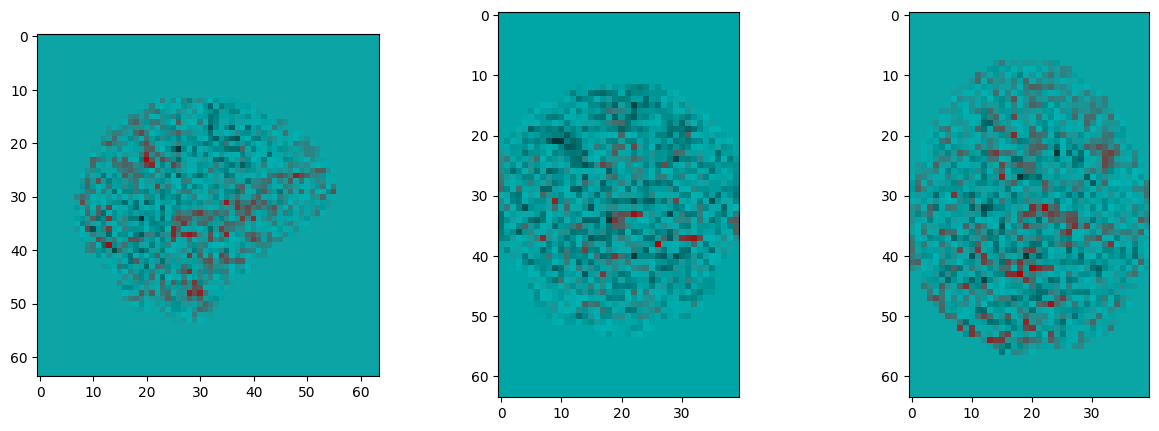

In [8]:
fig = plot_2d_projections(next(iter(DataLoader(train)))[0][0].numpy(), cmap=cmap)

In [9]:
X, Y = next(iter(DataLoader(train, 10)))

In [10]:
X.shape[1:]

torch.Size([40, 64, 64])

In [11]:
from copy import deepcopy
from deepmeg.training.callbacks import Trainer, Callback


class PenalizedEarlyStopping(Callback):
    def __init__(self, patience=5, monitor='loss_train', measure='binary_accuracy_train', min_delta=0, restore_best_weights=True):
        super().__init__()
        self.patience = patience
        self.monitor = monitor
        self.measure = measure
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.min_criterion_value = np.inf
        self.max_measure_value = -np.inf
        self.best_weights = None

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.model = self.trainer.model

    def on_epoch_end(self, epoch_num, metrics):
        criterion_value = metrics[self.monitor]
        measure_value = metrics[self.measure]
        if criterion_value < self.min_criterion_value or measure_value > self.max_measure_value:
            self.min_criterion_value = criterion_value
            self.counter = 0

            if measure_value > self.max_measure_value:
                self.best_weights = deepcopy(self.model.state_dict())
                self.max_measure_value = measure_value

        elif criterion_value > (self.min_criterion_value + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    self.restore()

                self.trainer.interrupt()

    def restore(self):
        self.model.load_state_dict(self.best_weights)

In [32]:
model = TcModel(
    X.shape[1:],
    (10, 10, 10),
    1,
    Y.shape[1],
    .4
)

optimizer = torch.optim.Adam#W(model.parameters(), lr=1e-3)
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        L2Reg(
            [
                'tc.kernel', *[f'tc.components.{i}' for i in range(3)]
            ],
            0.01
        ),
        PenalizedEarlyStopping(monitor='loss_val', measure='accuracy_val', restore_best_weights=True, patience=25)
    ]
)

In [28]:
model.maxpool_shape, model.num_features

((40, 64, 64), 163840)

In [35]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.8385   |    accuracy_train:  0.2247   |    loss_val:  0.8314   |    accuracy_val:  0.3644
Epoch 1:  loss_train:  0.8145   |    accuracy_train:  0.4932   |    loss_val:  0.8268   |    accuracy_val:  0.4597
Epoch 2:  loss_train:  0.7980   |    accuracy_train:  0.5656   |    loss_val:  0.8249   |    accuracy_val:  0.5014
Epoch 3:  loss_train:  0.7827   |    accuracy_train:  0.6560   |    loss_val:  0.8239   |    accuracy_val:  0.5403
Epoch 4:  loss_train:  0.7673   |    accuracy_train:  0.7154   |    loss_val:  0.8230   |    accuracy_val:  0.6000
Epoch 5:  loss_train:  0.7518   |    accuracy_train:  0.7717   |    loss_val:  0.8235   |    accuracy_val:  0.6454
Epoch 6:  loss_train:  0.7359   |    accuracy_train:  0.8272   |    loss_val:  0.8265   |    accuracy_val:  0.6583
Epoch 7:  loss_train:  0.7195   |    accuracy_train:  0.8532   |    loss_val:  0.8320   |    accuracy_val:  0.6884
Epoch 8:  loss_train:  0.7020   |    accuracy_train:  0.8805   |    loss_val:  0

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

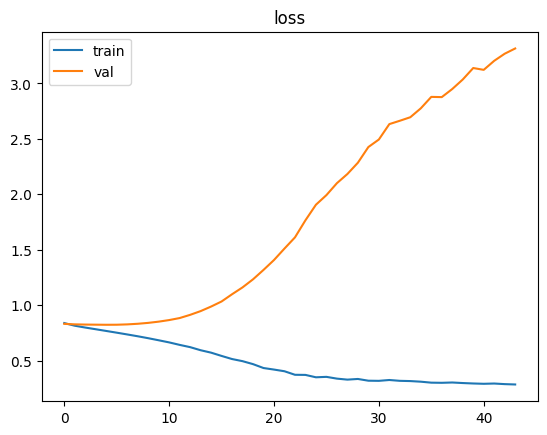

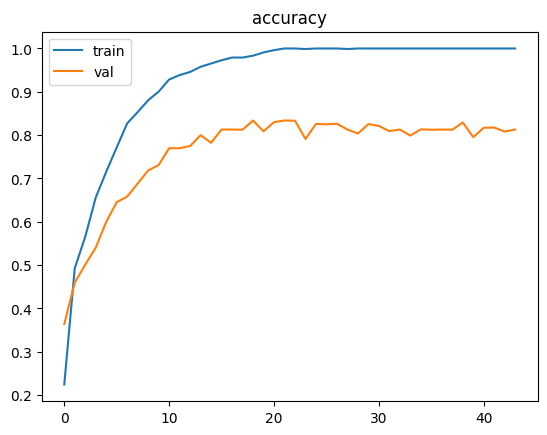

In [36]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [37]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.6182115294716575
train_accuracy: 0.9612961411476135
loss: 1.2614197080785579
accuracy: 0.8295983076095581


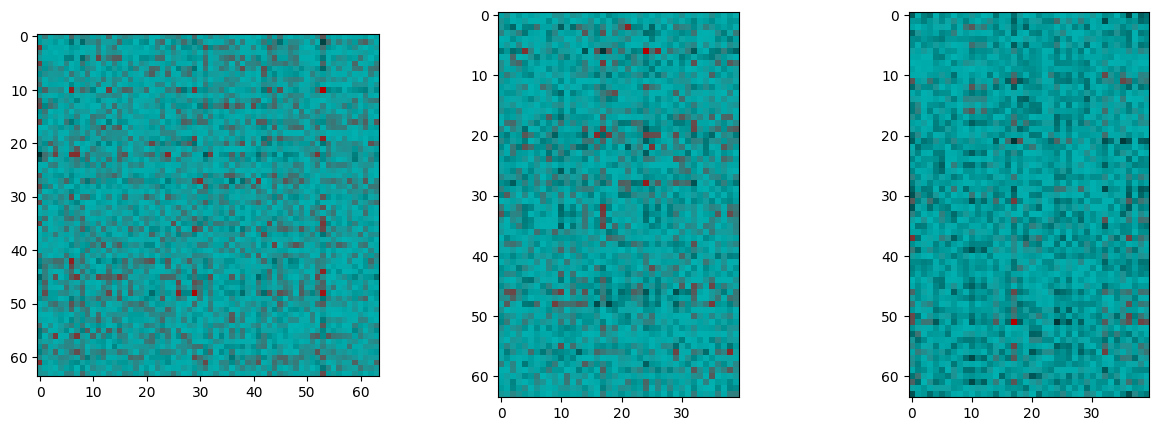

In [34]:
fig = plot_2d_projections(model.tc.get_weights().detach().numpy(), cmap=cmap)

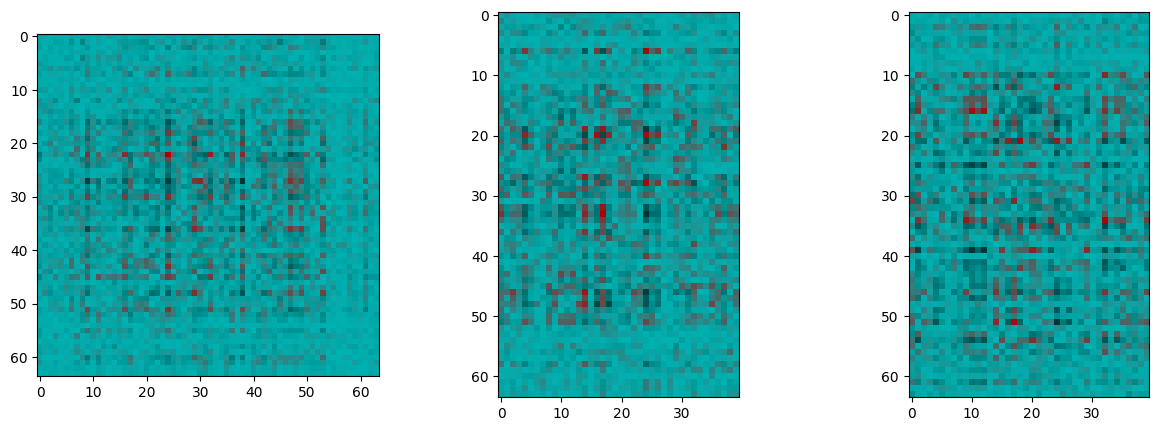

In [38]:
fig = plot_2d_projections(model.tc.get_weights().detach().numpy(), cmap=cmap)